# 02bb – Baseline (TF-IDF + Logistic Regression) – Split 80/10/10

Ziel: Ein klassisches ML-Baseline-Modell trainieren, um später den Mehrwert von BERT (Deep Learning) zu quantifizieren.

**Split-Strategie:** 80% Train / 10% Validation / 10% Test

In [1]:
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## 1) CSV laden

In [2]:
PROJECT_ROOT = Path.cwd().parent
CSV_PATH = PROJECT_ROOT / "data" / "processed" / "bbc_news.csv"

df = pd.read_csv(CSV_PATH, encoding="utf-8")
df.shape, df["label"].nunique()

((2225, 5), 5)

In [3]:
df.head(2)

,id,label,text,source_file,n_chars
0,1,business,Ad sales boost Time Warner profit\n\nQuarterly...,data\raw\bbc\business\001.txt,2559
1,2,business,Dollar gains on Greenspan speech\n\nThe dollar...,data\raw\bbc\business\002.txt,2252


## 2) Train/Validation/Test Split (80/10/10)

**Strategie:** 80% Train / 10% Validation / 10% Test
- Train: Modell trainieren (mehr Daten für Training)
- Validation: Hyperparameter-Tuning, Model Selection
- Test: Finale Evaluation (nur EINMAL am Schluss!)

In [4]:
SEED = 42
SPLIT_NAME = "80-10-10"

X = df["text"]
y = df["label"]

# Erst Train-Set abspalten (80%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

# Dann Val/Test aus dem Rest (50/50 von 20% = je 10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=SEED,
    stratify=y_temp
)

print(f"Split: {SPLIT_NAME}")
print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)
print(f"Actual Split: {len(X_train)/len(X)*100:.1f}% / {len(X_val)/len(X)*100:.1f}% / {len(X_test)/len(X)*100:.1f}%")
print("\nTrain label dist:\n", y_train.value_counts(normalize=True).round(3))
print("\nValidation label dist:\n", y_val.value_counts(normalize=True).round(3))
print("\nTest label dist:\n", y_test.value_counts(normalize=True).round(3))

Split: 80-10-10
Train: (1780,) Validation: (222,) Test: (223,)
Actual Split: 80.0% / 10.0% / 10.0%

Train label dist:
 label
sport            0.230
business         0.229
politics         0.187
tech             0.180
entertainment    0.174
Name: proportion, dtype: float64

Validation label dist:
 label
sport            0.230
business         0.230
politics         0.189
tech             0.180
entertainment    0.171
Name: proportion, dtype: float64

Test label dist:
 label
sport            0.229
business         0.229
politics         0.188
tech             0.179
entertainment    0.175
Name: proportion, dtype: float64


## 3) Baseline Modell: TF-IDF + Logistic Regression

In [5]:
baseline_clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1, 2),
        max_features=50000
    )),
    ("logreg", LogisticRegression(
        max_iter=2000,
        n_jobs=-1,
        class_weight=None
    ))
])
baseline_clf

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('logreg', LogisticRegression(max_iter=2000, n_jobs=-1))])

### Hyperparameter-Tuning mit Grid Search

Nutzt 5-Fold CV für Konsistenz.

In [6]:
# Parameter-Grid definieren
param_grid = {
    'tfidf__max_features': [10000, 30000, 50000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'logreg__C': [0.1, 1.0, 10.0]
}

# GridSearchCV mit 5-Fold CV
grid_search = GridSearchCV(
    baseline_clf,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("Starte Grid Search mit 5-Fold CV...")
grid_search.fit(X_train, y_train)

print("\n✅ Grid Search abgeschlossen!")
print("Beste Parameter:", grid_search.best_params_)
print("Beste CV-Accuracy:", round(grid_search.best_score_, 4))

baseline_clf = grid_search.best_estimator_

Starte Grid Search mit 5-Fold CV...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

✅ Grid Search abgeschlossen!
Beste Parameter: {'logreg__C': 1.0, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}
Beste CV-Accuracy: 0.9775


## 4) Evaluation auf Validation Set

In [7]:
y_val_pred = baseline_clf.predict(X_val)
acc_val = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", round(acc_val, 4))

Validation Accuracy: 0.9865


In [8]:
print(classification_report(y_val, y_val_pred))

               precision    recall  f1-score   support

     business       1.00      0.96      0.98        51
entertainment       1.00      1.00      1.00        38
     politics       1.00      0.98      0.99        42
        sport       0.98      1.00      0.99        51
         tech       0.95      1.00      0.98        40

     accuracy                           0.99       222
    macro avg       0.99      0.99      0.99       222
 weighted avg       0.99      0.99      0.99       222



## Confusion Matrix (Validation Set)

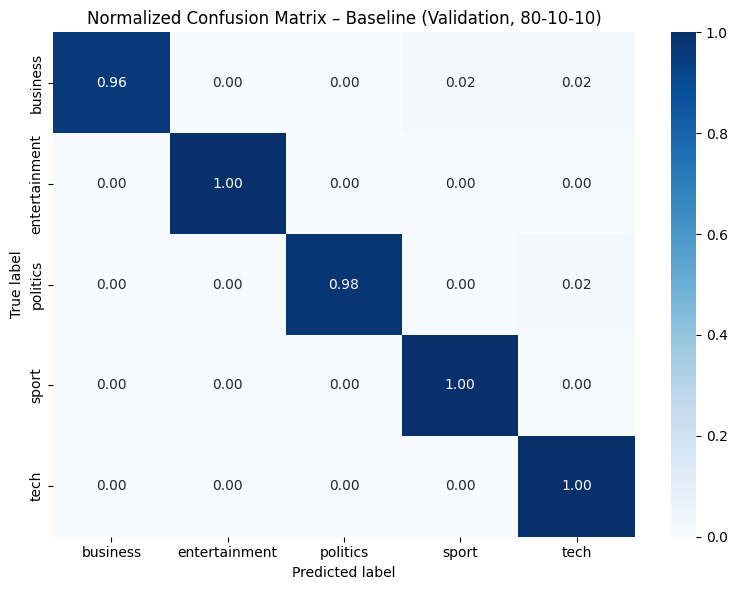

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

labels_sorted = sorted(df["label"].unique())
cm = confusion_matrix(y_val, y_val_pred, labels=labels_sorted)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Normalized Confusion Matrix – Baseline (Validation, {SPLIT_NAME})")
plt.tight_layout()
plt.show()

## 5) Data Leakage Check

In [10]:
train_texts = set(X_train)
val_texts = set(X_val)
test_texts = set(X_test)

print("Train ∩ Val:", len(train_texts.intersection(val_texts)))
print("Train ∩ Test:", len(train_texts.intersection(test_texts)))
print("Val ∩ Test:", len(val_texts.intersection(test_texts)))
print("\n✅ Alle sollten 0 sein!")

Train ∩ Val: 20
Train ∩ Test: 13
Val ∩ Test: 0

✅ Alle sollten 0 sein!


## 6) Finale Evaluation auf Test-Set

**Nur EINMAL am Schluss!**

In [11]:
y_test_pred = baseline_clf.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)

print("=" * 60)
print(f"FINALE TEST-SET EVALUATION (Split: {SPLIT_NAME})")
print("=" * 60)
print(f"Test Accuracy: {acc_test:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

FINALE TEST-SET EVALUATION (Split: 80-10-10)
Test Accuracy: 0.9910

Classification Report:
               precision    recall  f1-score   support

     business       1.00      0.96      0.98        51
entertainment       1.00      1.00      1.00        39
     politics       0.98      1.00      0.99        42
        sport       1.00      1.00      1.00        51
         tech       0.98      1.00      0.99        40

     accuracy                           0.99       223
    macro avg       0.99      0.99      0.99       223
 weighted avg       0.99      0.99      0.99       223



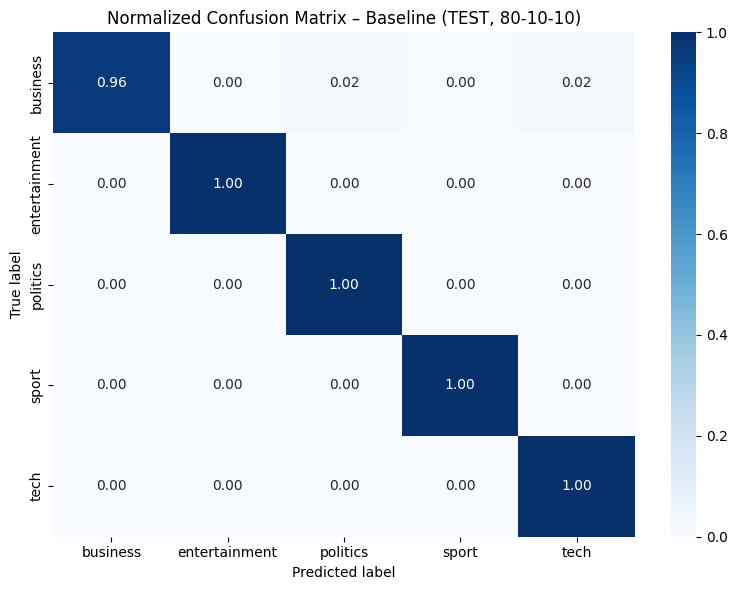


✅ Gespeichert: c:\CAS\cas-ml-document-classification\results\baseline_confusion_matrix_TEST_80-10-10.png


In [12]:
from sklearn.metrics import f1_score

cm_test = confusion_matrix(y_test, y_test_pred, labels=labels_sorted)
cm_test_norm = cm_test.astype("float") / cm_test.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Normalized Confusion Matrix – Baseline (TEST, {SPLIT_NAME})")
plt.tight_layout()

# Speichern
fig_path_test = PROJECT_ROOT / "results" / f"baseline_confusion_matrix_TEST_{SPLIT_NAME}.png"
fig_path_test.parent.mkdir(exist_ok=True)
plt.savefig(fig_path_test, dpi=300)
plt.show()
print(f"\n✅ Gespeichert: {fig_path_test}")

## 7) Ergebnisse speichern (für Vergleich)

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score

results_dict = {
    "model": "TF-IDF + LogReg",
    "split": SPLIT_NAME,
    "train_size": len(X_train),
    "val_size": len(X_val),
    "test_size": len(X_test),
    "val_accuracy": acc_val,
    "test_accuracy": acc_test,
    "test_macro_f1": f1_score(y_test, y_test_pred, average="macro"),
    "test_macro_precision": precision_score(y_test, y_test_pred, average="macro"),
    "test_macro_recall": recall_score(y_test, y_test_pred, average="macro"),
    "best_params": str(grid_search.best_params_)
}

results_df = pd.DataFrame([results_dict])
results_path = PROJECT_ROOT / "results" / f"baseline_results_{SPLIT_NAME}.csv"
results_df.to_csv(results_path, index=False)
print(f"✅ Ergebnisse gespeichert: {results_path}")
results_df

✅ Ergebnisse gespeichert: c:\CAS\cas-ml-document-classification\results\baseline_results_80-10-10.csv


,model,split,train_size,val_size,test_size,val_accuracy,test_accuracy,test_macro_f1,test_macro_precision,test_macro_recall,best_params
0,TF-IDF + LogReg,80-10-10,1780,222,223,0.986486,0.991031,0.991178,0.990471,0.992157,"{'logreg__C': 1.0, 'tfidf__max_features': 1000..."
